# ECSE 415 Assignment 3, Question 1
### Alex Hale | 260672475 | November 5, 2019

## Segmentation

In [1]:
# basic
import math
import cv2
import numpy as np
import matplotlib.pyplot as plt

# SciPy
from scipy.stats import multivariate_normal

# SciKit
import sklearn
from skimage import segmentation, color
from skimage.future import graph
from sklearn.mixture import GaussianMixture
from sklearn.datasets import make_spd_matrix

### 2.1 - K-means Clustering and Expectation Maximization
#### Implementation of K-Means

In [2]:
# data: matrix of size num_datapoints x num_features
# K: number of clusters
# max_iter: maximum number of iterations that the algorithm will be permitted to run
# accuracy: minimum distance the cluster centers must move in order to iterate again
def kmeans(data, K, max_iter=50, accuracy=0.5):
    # initialize return variables
    labelsList = np.empty((6, data.shape[0]))
    centersList = np.empty((6, K, data.shape[1]))
    
    # initialize K cluster centers at random values from the data set
    centers = np.asarray([data[np.random.randint(0, data.shape[0] - 1)] for k in range(K)])
    
    cur_iter = 0
    acc = np.inf
    while (cur_iter < max_iter and acc > accuracy):
        # determine the label of each point:
        labels = np.asarray([np.argmin([np.linalg.norm(d - c) for c in centers]) for d in data])

        # given the points in each cluster, solve for the centers c_i
        old_centers = centers.copy()
        centers = np.asarray([np.mean(data[labels.ravel() == idx], axis=0) for idx in range(K)])

        # if there was a significant change in any of the centers, repeat
        acc = np.linalg.norm([np.linalg.norm(oc - c) for oc, c in zip(old_centers, centers)])
        
        # send back the progress data from the first 5 loops
        if cur_iter < 5:
            labelsList[cur_iter] = labels.copy()
            centersList[cur_iter] = centers.copy()

        # increment iteration counter
        cur_iter += 1
    
    while (cur_iter < 5):
        labelsList[cur_iter] = labels.copy()
        centersList[cur_iter] = centers.copy()
        cur_iter += 1

    labelsList[5] = labels
    centersList[5] = centers
    return labelsList, centersList

#### Implementation of Expectation Maximization

In [3]:
# data: matrix of size num_datapoints x num_features
# K: number of clusters
# max_iter: maximum number of iterations that the algorithm will be permitted to run
# accuracy: minimum distance the cluster centers must move in order to iterate again
def em(data, K, max_iter=50, accuracy=0.5):
    # ensure no divide-by-zero
    eps=1e-16
    
    # initialize return variables
    labelsList = np.empty((6, data.shape[0]))
    centersList = np.empty((6, K, data.shape[1]))
    
    # initialize the GMM with K means, variances, and alphas
    alphas = np.full((K), 1 / K)
    means = np.ones((K, data.shape[1]))
    variances = np.ones((K, data.shape[1], data.shape[1]))
    for k, split in enumerate(np.split(data, K)):
        # means[k] = np.asarray([np.mean(split[:][i]) for i in range(data.shape[1])])
        means[k] = data[np.random.randint(0, data.shape[0])]
        variances[k] = np.cov(split, rowvar=False)

    cur_iter = 0
    acc = np.inf
    while (cur_iter < max_iter and acc > accuracy):        
        # Expectation: determine the label of each point based on current GMM parameters
        baseProbs = np.array([alphas[k] * multivariate_normal.pdf(x=data, mean=means[k], cov=variances[k], allow_singular=True) for k in range(K)])
        baseProbs /= np.sum([baseProbs[i] + eps for i in range(K)]) 
        labels = np.argmax(baseProbs, axis=0)
    
        # Maximization: given the newly-calculated labels, update the model parameters (mean, variance, alpha)
        newAlphas = np.zeros((alphas.shape))
        newMeans = np.zeros((means.shape))
        newVariances = np.zeros((variances.shape))
        for k in range(K):
            newAlphas[k] = np.sum(baseProbs[k])
            reshaped = baseProbs[k].reshape(data.shape[0], 1)
            newMeans[k] = np.sum(reshaped * data, axis=0) / (newAlphas[k] + eps)
            subtracted = np.subtract(data, means[k])
            newVariances[k] = np.dot((reshaped * subtracted).T, subtracted) / (newAlphas[k] + eps)
            newAlphas[k] = np.mean(newAlphas[k])

        # accuracy check: use the centres to determine whether the result are yet good enough to stop looping       
        acc = np.linalg.norm(means - newMeans)
        
        # send back the progress data from the first 5 loops
        if cur_iter < 5:
            labelsList[cur_iter] = labels.copy()
            centersList[cur_iter] = means.copy()
        
        alphas = newAlphas
        means = newMeans
        variances = newVariances
        cur_iter += 1
    
    while (cur_iter < 5):
        labelsList[cur_iter] = labels.copy()
        centersList[cur_iter] = means.copy()
        cur_iter += 1

    labelsList[5] = labels
    centersList[5] = means    
    return labelsList, centersList

#### Execution of K-Means and EM

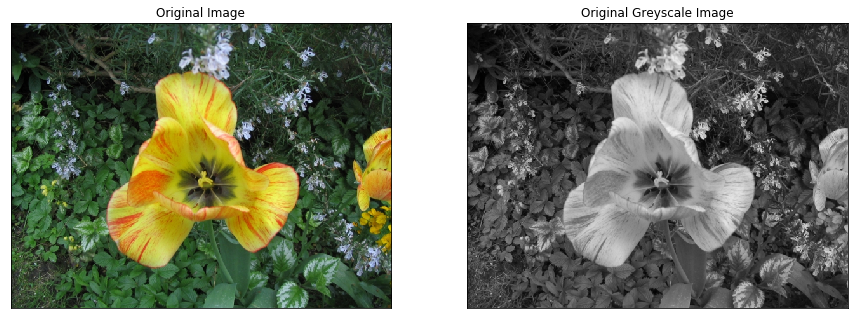

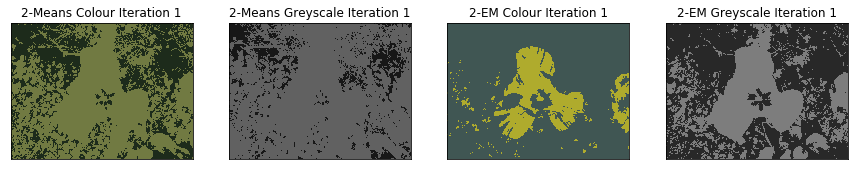

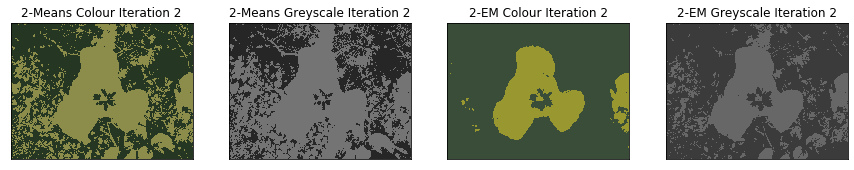

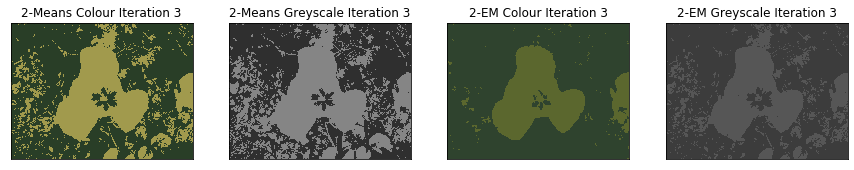

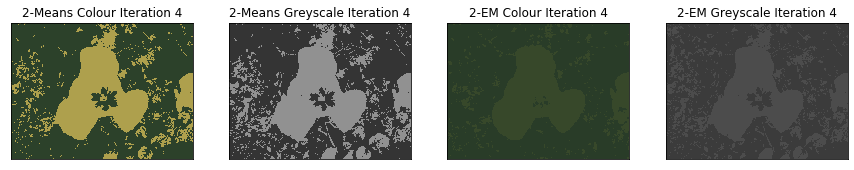

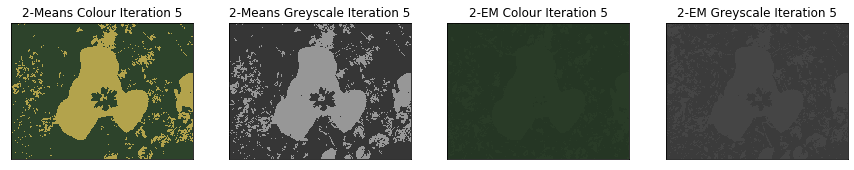

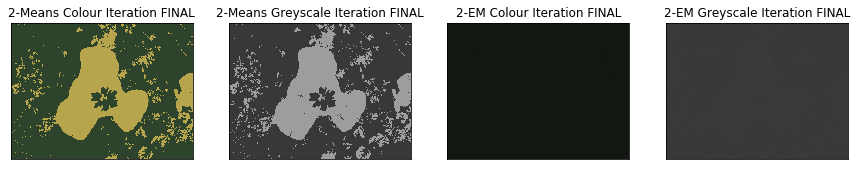

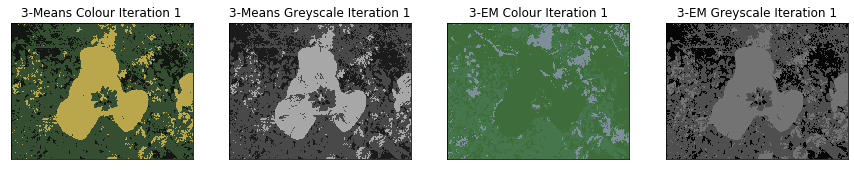

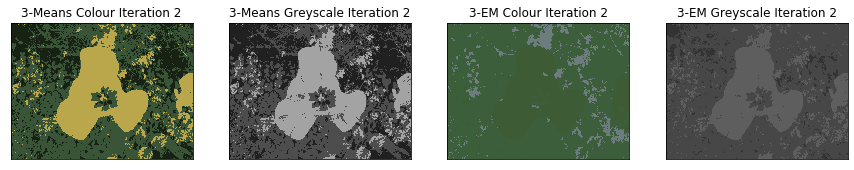

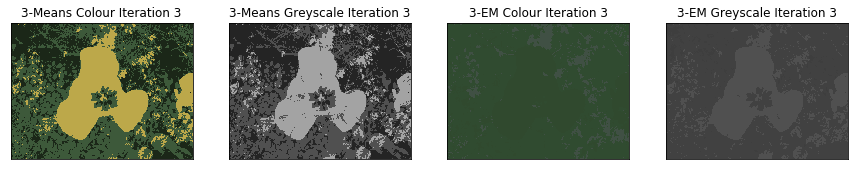

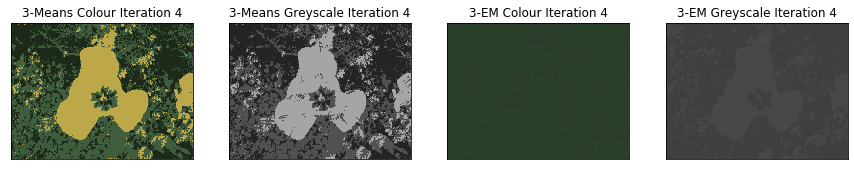

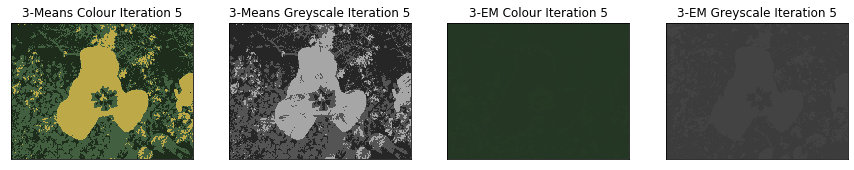

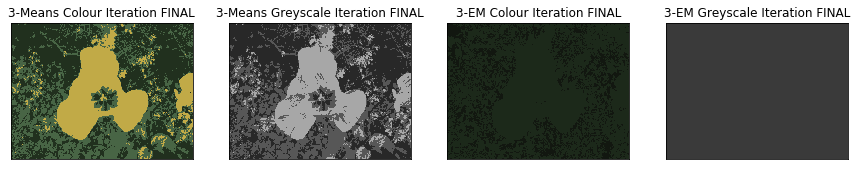

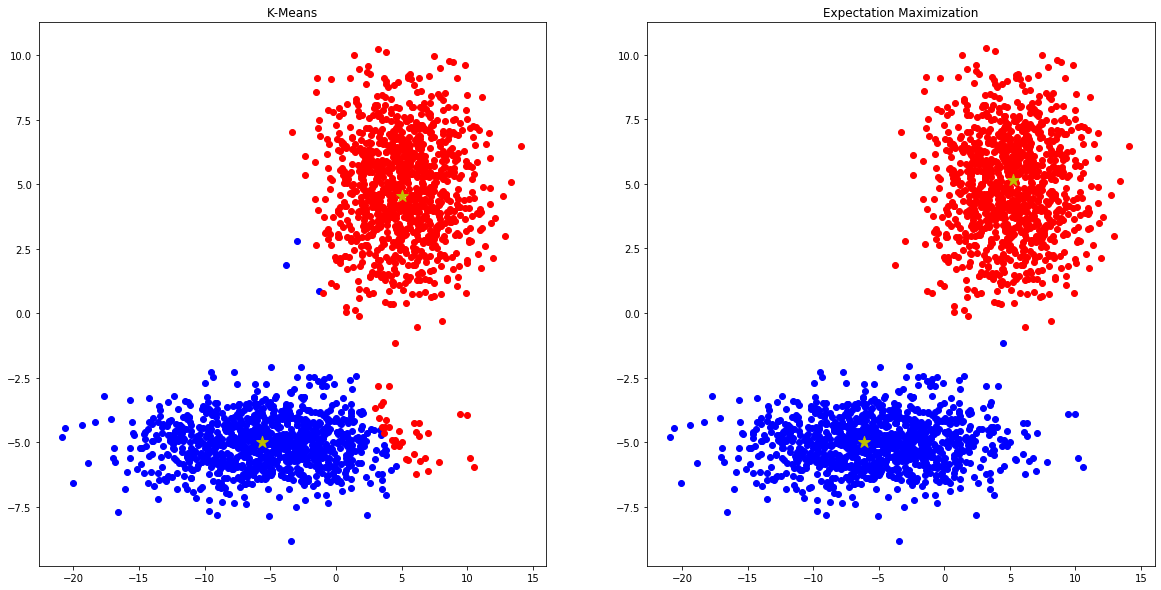

In [8]:
# load in image
img = cv2.cvtColor(cv2.imread('flower.jpg'), cv2.COLOR_BGR2RGB)
img_g = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# display original image
plt.figure(figsize=(15, 15))
plt.subplot(121), plt.imshow(img), plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_g, cmap="gray", vmin=0, vmax=255), plt.title("Original Greyscale Image"), plt.xticks([]), plt.yticks([]) 
plt.show()

# reshape the image into an array of pixels (rather than a matrix)
img_data = np.float32(img.reshape((img.shape[0] * img.shape[1], 3)))
img_g_data = np.float32(img_g.reshape((img_g.shape[0] * img_g.shape[1], 1)))

for K in [2, 3]:
    # execute K-Means 
    labelsList, centersList = kmeans(img_data, K)
    labelsList_g, centersList_g = kmeans(img_g_data, K)
    
    # execute EM
    labelsList_gm, centersList_gm = em(img_data, K)
    labelsList_gm_g, centersList_gm_g = em(img_g_data, K)
    
    # convert back into uint8 and display output images
    idx = 1
    for labels, centers, labels_g, centers_g, labels_gm, centers_gm, labels_gm_g, centers_gm_g in zip(labelsList, centersList, labelsList_g, centersList_g,labelsList_gm, centersList_gm, labelsList_gm_g, centersList_gm_g):
        
        # K-Means image prep
        centers = np.uint8(centers)
        labels = np.uint8(labels)
        out = centers[labels.flatten()].reshape((img.shape))
        centers_g = np.uint8(centers_g)
        labels_g = np.uint8(labels_g)
        out_g = centers_g[labels_g.flatten()].reshape((img_g.shape))
        
        # EM image prep
        centers_gm = np.uint8(centers_gm)
        labels_gm = np.uint8(labels_gm)
        out_gm = centers_gm[labels_gm.flatten()].reshape((img.shape))
        centers_gm_g = np.uint8(centers_gm_g)
        labels_gm_g = np.uint8(labels_gm_g)
        out_gm_g = centers_gm_g[labels_gm_g.flatten()].reshape((img_g.shape))
        
        plt.figure(figsize=(15, 15))
        plt.subplot(141)
        plt.imshow(out)
        plt.title("{}-Means Colour Iteration {}".format(K, idx)), plt.xticks([]), plt.yticks([])
        plt.subplot(142)
        plt.imshow(out_g, cmap='gray', vmin=0, vmax=255)
        plt.title("{}-Means Greyscale Iteration {}".format(K, idx)), plt.xticks([]), plt.yticks([])
        plt.subplot(143)
        plt.imshow(out_gm)
        plt.title("{}-EM Colour Iteration {}".format(K, idx)), plt.xticks([]), plt.yticks([])
        plt.subplot(144)
        plt.imshow(out_gm_g, cmap='gray', vmin=0, vmax=255)
        plt.title("{}-EM Greyscale Iteration {}".format(K, idx)), plt.xticks([]), plt.yticks([])
        plt.show()
        
        if idx == 5 or idx == 'FINAL':
            idx = "FINAL"
        else:
            idx += 1
            
# random data experimentation on K-Means and EM
randomData = np.float32(np.vstack((np.random.normal(loc=np.array([5,5]), scale=np.array([3,2]), size =(1000,2)),
                             np.random.normal(loc=np.array([-5,-5]), scale=np.array([5,1]), size=(1000,2)))))

labels, centers = kmeans(randomData, 2)
A = randomData[np.asarray(labels)[-1].ravel() == 0]
B = randomData[np.asarray(labels)[-1].ravel() == 1]

labels_em, centers_em = em(randomData, 2)
A_em = randomData[np.asarray(labels_em)[-1].ravel() == 0]
B_em = randomData[np.asarray(labels_em)[-1].ravel() == 1]

plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.scatter(A[:,0], A[:,1], color='b')
plt.scatter(B[:,0], B[:,1], color='r')
plt.scatter((centers[-1][0][0], centers[-1][1][0]), (centers[-1][0][1], centers[-1][1][1]), s=150, color='y', marker='*')
plt.title("K-Means")
plt.subplot(122)
plt.scatter(A_em[:,0], A_em[:,1], color='b')
plt.scatter(B_em[:,0], B_em[:,1], color='r')
plt.scatter((centers_em[-1][0][0], centers_em[-1][1][0]), (centers_em[-1][0][1], centers_em[-1][1][1]), s=150, color='y', marker='*')
plt.title("Expectation Maximization")
plt.show()

##### K-Means Clustering
The segmentation graph of the K-Means implementation is better for the colour image than for the greyscale image. This is because K-Means segmentation uses the hard mean-squared distance to group data to its nearest centre, resulting in better performance for data with more features. 

##### Expectation Maximization Clustering
The segmentation graph of the Expectation Maximization implementation should be better for the greyscale image than for the colour image. This is because EM segmenetation uses Gaussian distributions to group data to its nearest cluster centre, resulting in better performance for data with fewer features.

### 2.2 - Normalized Graph-Cut and Mean-Shift segmentation
#### Normalized Graph-Cut

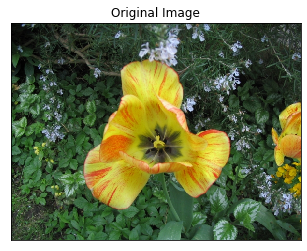

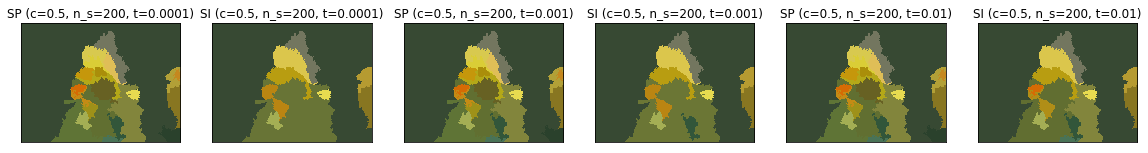

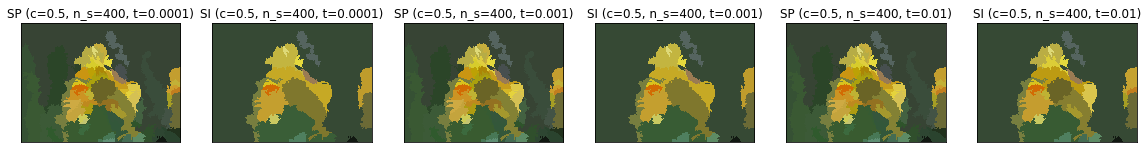

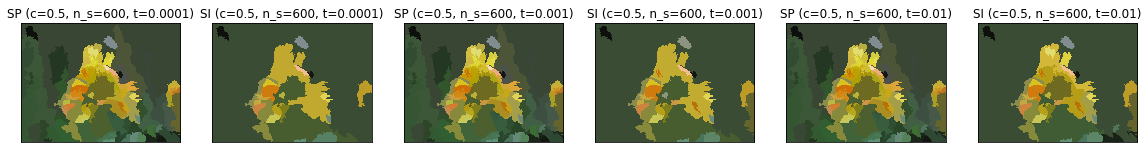

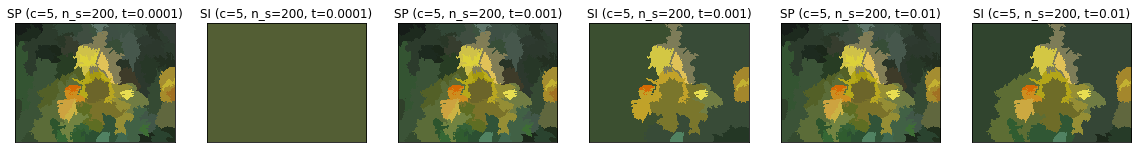

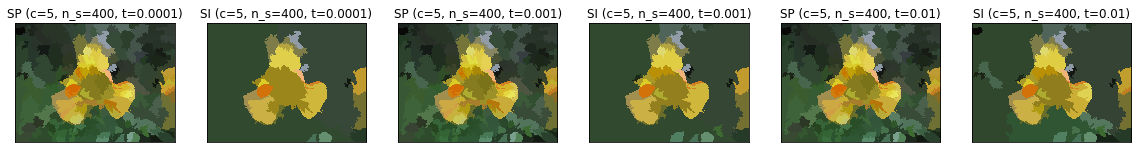

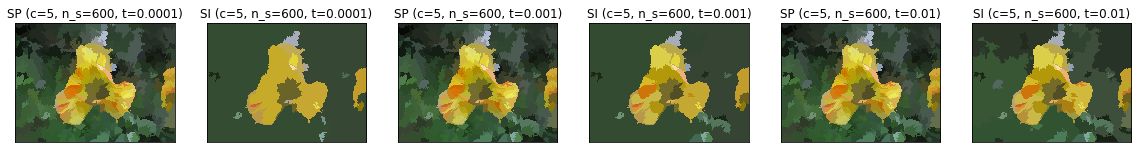

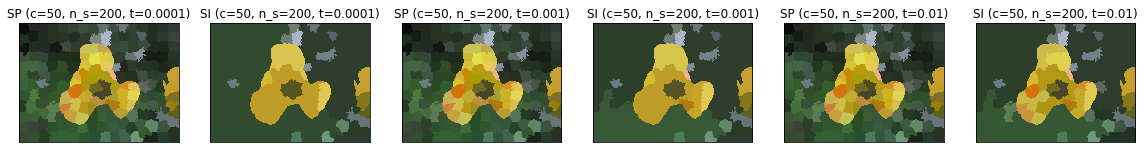

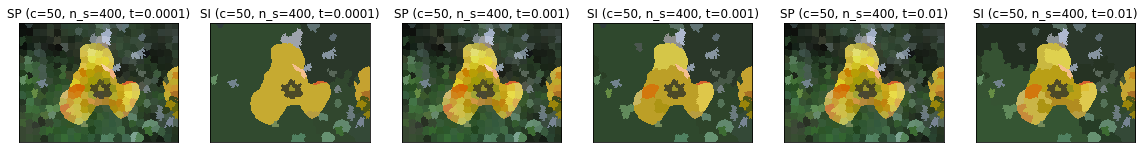

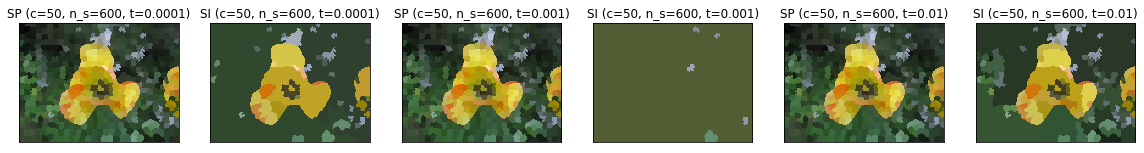

In [5]:
# Read image
img = cv2.cvtColor(cv2.imread('flower.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(img), plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.show()

for c in [0.5, 5, 50]:
    for n_s in [200, 400, 600]:
        idx = 1
        plt.figure(figsize=(20,150))
        for t in [0.0001, 0.001, 0.01]:
            # generate super-pixels by applying K-Means
            super_pixels = segmentation.slic(img, compactness=c, n_segments=n_s)

            # build region adjacency graph
            g = graph.rag_mean_color(img, super_pixels, mode='similarity')

            # apply graph cut
            graph_cut = graph.cut_normalized(super_pixels, g, thresh=t)

            # display
            plt.subplot(int(str(16) + str(idx))), plt.imshow(color.label2rgb(super_pixels, img, kind='avg'))
            # super-pixel image
            plt.title("SP (c={}, n_s={}, t={})".format(c, n_s, t)), plt.xticks([]), plt.yticks([])
            plt.subplot(int(str(16) + str(idx+1))), plt.imshow(color.label2rgb(graph_cut, img, kind='avg'))
            # segmented image
            plt.title("SI (c={}, n_s={}, t={})".format(c, n_s, t)), plt.xticks([]), plt.yticks([])
            idx += 2
        plt.show()

Compactness: This parameter is the balance between color proximity and space proximity. A higher compactness value gives more weight to space proximity, which restricts the superpixels to be more square. A lower compactness value gives more weight to colour proximity, which for this image, makes the superpixels larger and more irregularly-shaped.

Number of Segments: This parameter is the (approximate) number of labels in the super-pixel (SP) output image. A higher number of labels means that more detail is preserved, while a lower number of labels results in less detail being preserved.

Threshold: This parameter limits the subdivision of the region adjacency graph. A subgraph won’t be further subdivided if the value of the N-cut exceeds this threshold. A larger threshold allows more of the detail from the super-pixel image into the segmented image, and vice versa. 

#### Mean-Shift Segmentation

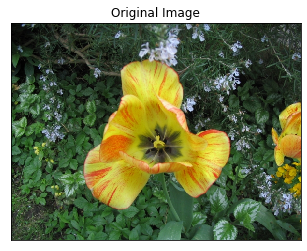

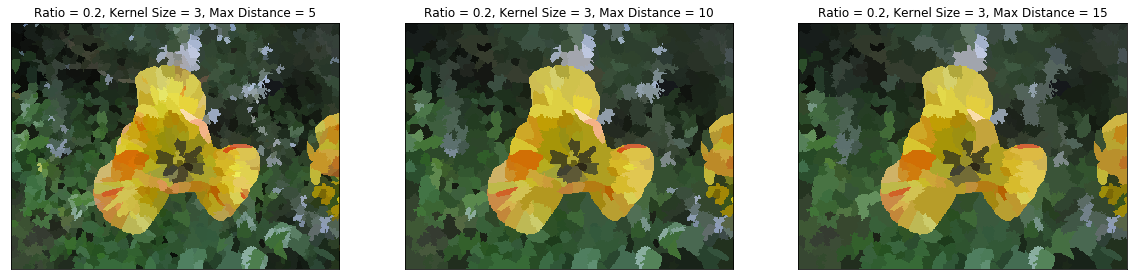

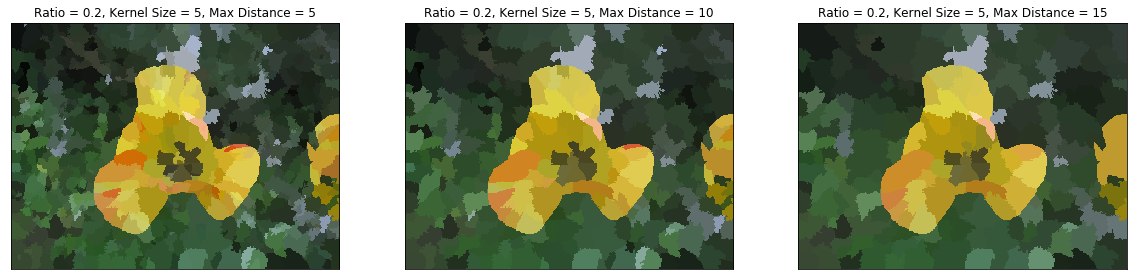

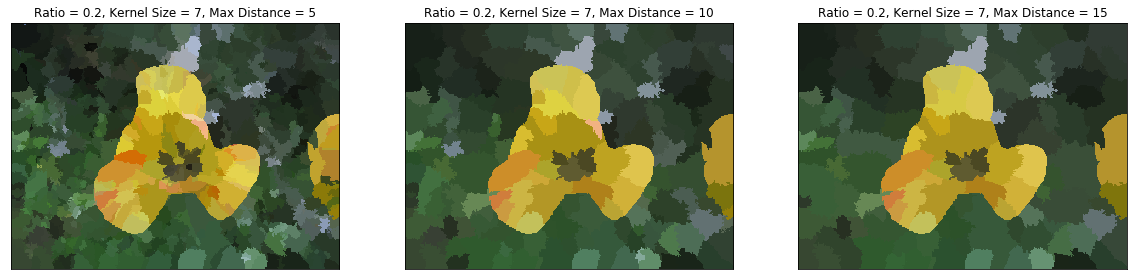

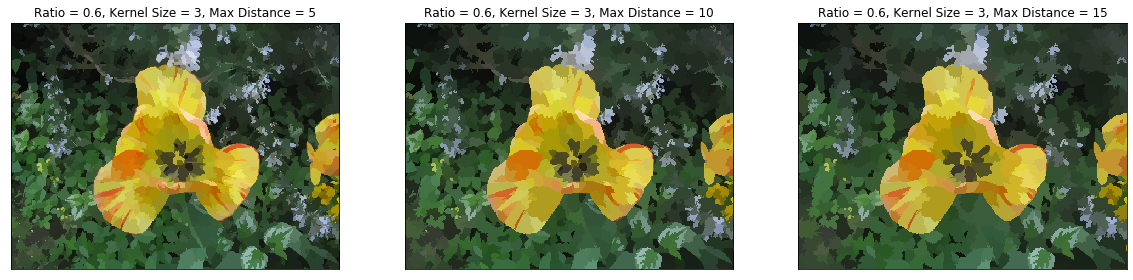

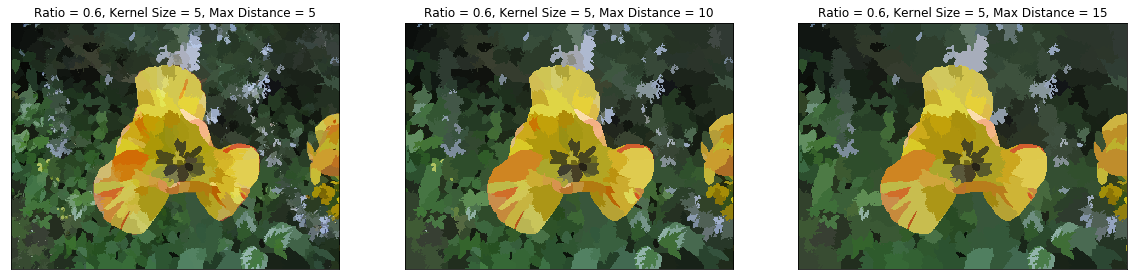

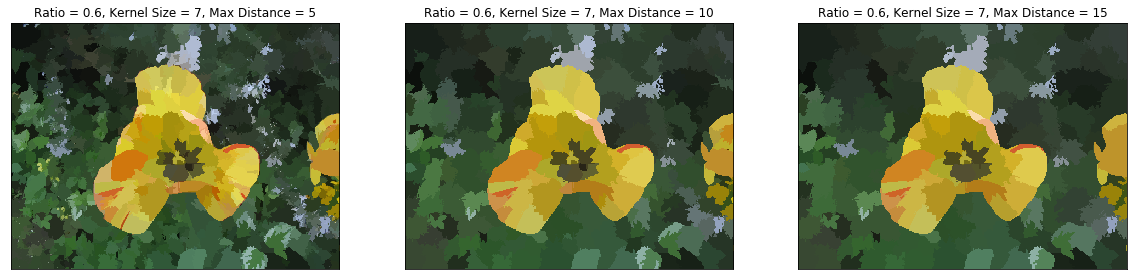

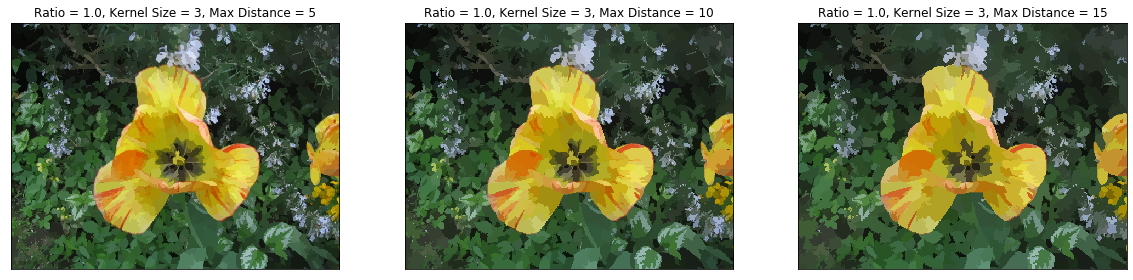

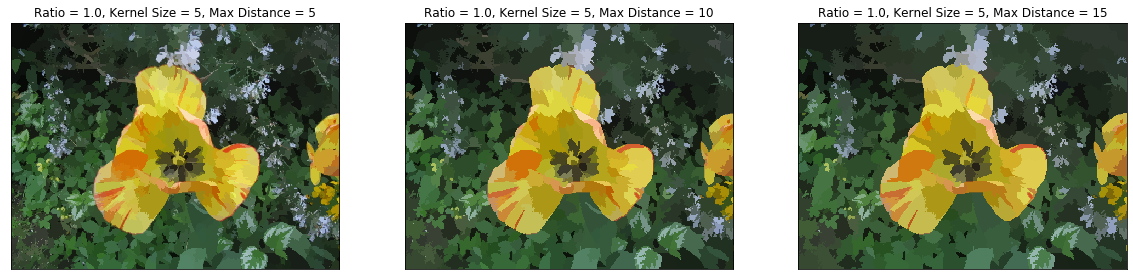

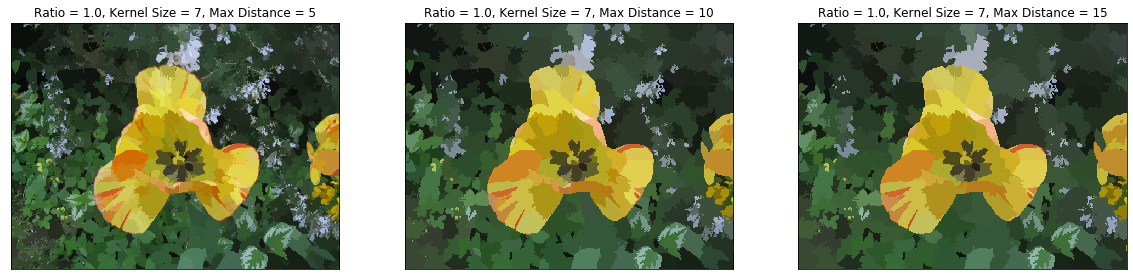

In [6]:
# Read image
img = cv2.cvtColor(cv2.imread('flower.jpg'), cv2.COLOR_BGR2RGB)
plt.imshow(img), plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.show()

for r in [0.2, 0.6, 1.0]:
    for k in [3, 5, 7]:
        idx = 1
        plt.figure(figsize=(20, 20))
        for m in [5, 10, 15]:
            # apply meanshift
            label = segmentation.quickshift(img, ratio=r, kernel_size=k, max_dist=m)

            # display
            plt.subplot(int(str(13) + str(idx)))
            idx += 1
            plt.imshow(color.label2rgb(label, img, kind='avg'))
            plt.title("Ratio = {}, Kernel Size = {}, Max Distance = {}".format(r, k, m)), plt.xticks([]), plt.yticks([])
        plt.show()

Ratio: This parameter is the balance between colour-space proximity and image-space proximity, where 1.0 is entirely colour-space and 0.0 is entirely image-space. Practically, since this image has many areas with similar intensities but varying colours, this means that a higher ratio results in an image with more clusters (i.e. more detail), while a lower ratio results in an image with fewer clusters (i.e. less detail) of a more square shape. 

Kernel Size: This parameter is the width of the Gaussian kernel used to smooth the sample density. A higher kernel size performs more smoothing, which results in fewer clusters (i.e. less detail). A lower kernel size performs less smoothing, which results in more clusters (i.e. more detail).

Max Distance: This parameter is the maximum distance that a data point can be from a node in order to be included in that node's cluster. A higher max distance means that each cluster includes more data points, resulting in fewer clusters (i.e. less detail). A lower max distance means that each cluster includes fewer data points, resulting in more clusters (i.e. more detail).

### Benchmark: OpenCV's K-Means Clustering and Expectation Maximization Algorithms
Used solely for comparison to the results of my implementation above.

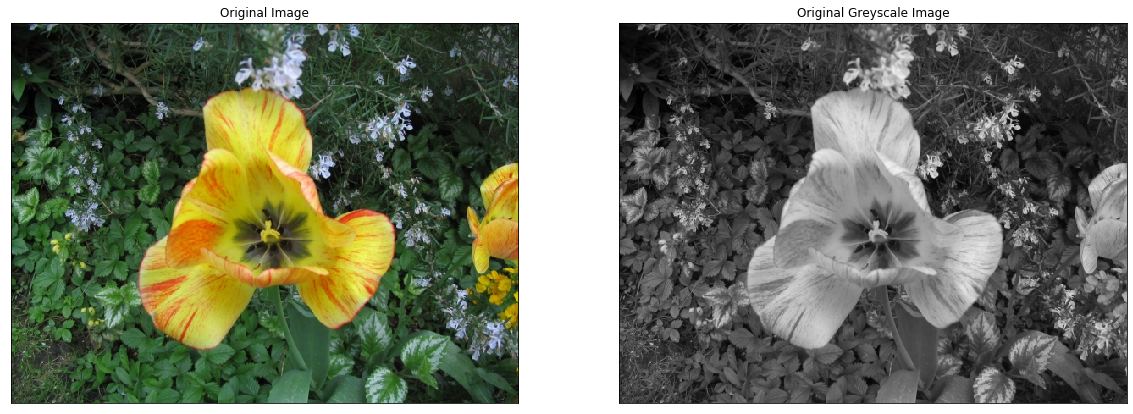

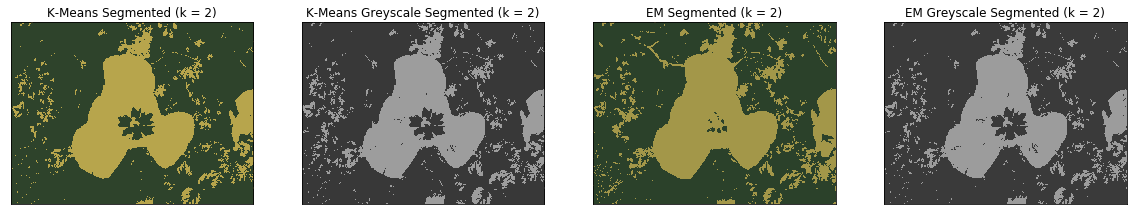

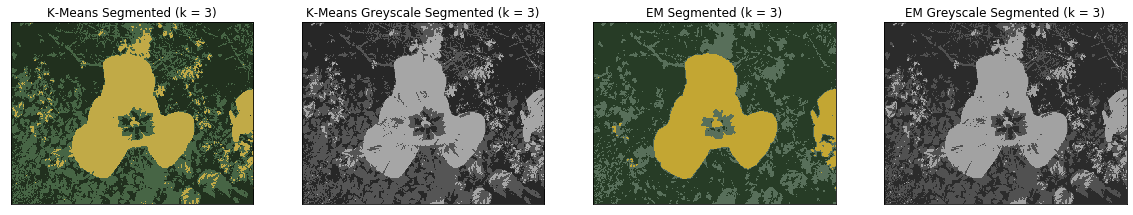

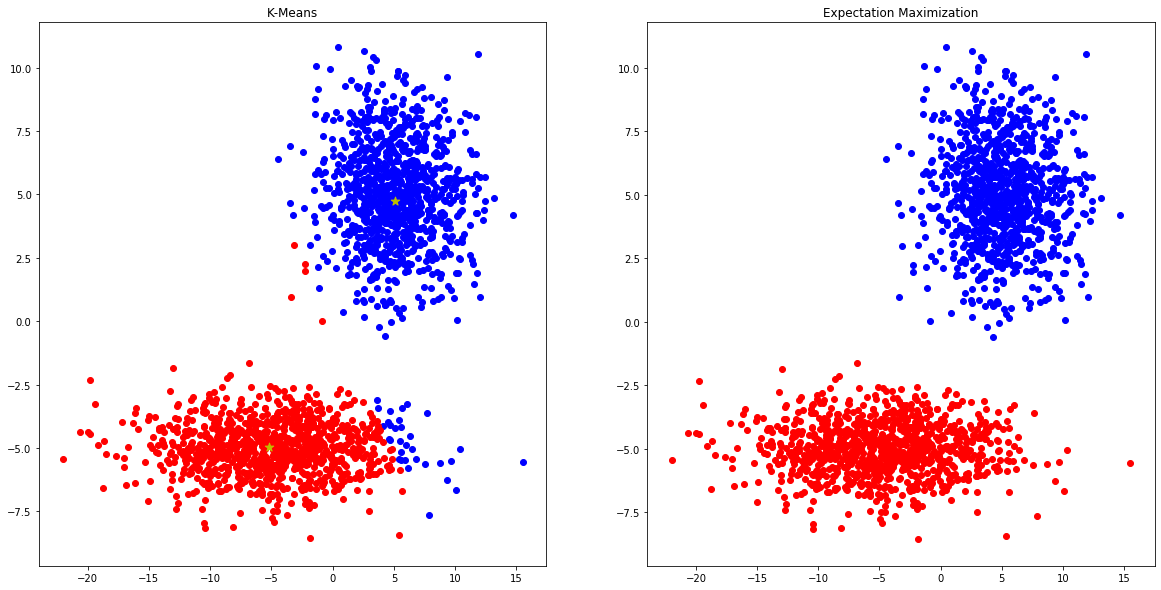

In [7]:
# load in image
img = cv2.cvtColor(cv2.imread('flower.jpg'), cv2.COLOR_BGR2RGB)
img_g = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

# display original image
plt.figure(figsize=(20, 20))
plt.subplot(121), plt.imshow(img), plt.title("Original Image"), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(img_g, cmap="gray", vmin=0, vmax=255), plt.title("Original Greyscale Image"), plt.xticks([]), plt.yticks([]) 

# reshape the image into an array of pixels (rather than a matrix)
img_data = np.float32(img.reshape((img.shape[0] * img.shape[1], 3)))
img_g_data = np.float32(img_g.reshape((img_g.shape[0] * img_g.shape[1], 1)))

# stopping criteria: stop when either 100 iterations or an accuracy of 1 is reached
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1)

# iterate through number of clusters
for K in [2,3]:
    # execute K-Means
    compactness, labels, centers = cv2.kmeans(img_data, K, None, criteria, 10, flags=cv2.KMEANS_RANDOM_CENTERS)
    compactness_g, labels_g, centers_g = cv2.kmeans(img_g_data, K, None, criteria, 10, flags=cv2.KMEANS_RANDOM_CENTERS)

    # convert back into uint8 and create output image
    centers = np.uint8(centers)
    out = centers[labels.flatten()].reshape((img.shape))
    centers_g = np.uint8(centers_g)
    out_g = centers_g[labels_g.flatten()].reshape((img_g.shape))

    # execute expectation maximization
    gm = GaussianMixture(n_components=K, covariance_type='full')
    labels_gm = gm.fit_predict(img_data).reshape((img.shape[0], img.shape[1]))
    centers_gm = gm.means_
    gm_g = GaussianMixture(n_components=K, covariance_type='full')
    labels_gm_g = gm_g.fit_predict(img_g_data).reshape((img_g.shape))
    centers_gm_g = gm_g.means_
    
    # convert back into uint8 and create output images
    centers_gm = np.uint8(centers_gm)
    out_gm = centers_gm[labels_gm.flatten()].reshape((img.shape))
    centers_gm_g = np.uint8(centers_gm_g)
    out_gm_g = centers_gm_g[labels_gm_g.flatten()].reshape((img_g.shape))
    
    plt.figure(figsize=(20,20))
    plt.subplot(141)
    plt.imshow(out)
    plt.title("K-Means Segmented (k = {})".format(K)), plt.xticks([]), plt.yticks([])
    plt.subplot(142)
    plt.imshow(out_g, cmap='gray', vmin=0, vmax=255)
    plt.title("K-Means Greyscale Segmented (k = {})".format(K)), plt.xticks([]), plt.yticks([])
    plt.subplot(143)
    plt.imshow(out_gm)
    plt.title("EM Segmented (k = {})".format(K)), plt.xticks([]), plt.yticks([])
    plt.subplot(144)
    plt.imshow(out_gm_g, cmap='gray', vmin=0, vmax=255)
    plt.title("EM Greyscale Segmented (k = {})".format(K)), plt.xticks([]), plt.yticks([])
    plt.show()
    
# random data experimentation on K-Means and EM
data = np.float32(np.vstack((np.random.normal(loc=np.array([5,5]), scale=np.array([3,2]), size =(1000,2)),
                             np.random.normal(loc=np.array([-5,-5]), scale=np.array([5,1]), size=(1000,2)))))

compactness, labels, centers = cv2.kmeans(data, 2, None, criteria, 10, flags=cv2.KMEANS_RANDOM_CENTERS)

A = data[labels.ravel() == 0]
B = data[labels.ravel() == 1]

em_labels = GaussianMixture(2).fit_predict(data)
A_em = data[em_labels.ravel() == 0]
B_em = data[em_labels.ravel() == 1]

plt.figure(figsize=(20, 10))
plt.subplot(121)
plt.scatter(A[:,0], A[:,1], color='b')
plt.scatter(B[:,0], B[:,1], color='r')
plt.scatter(centers[:,0], centers[:,1], s=80, color='y', marker='*')
plt.title("K-Means")
plt.subplot(122)
plt.scatter(A_em[:,0], A_em[:,1], color='b')
plt.scatter(B_em[:,0], B_em[:,1], color='r')
plt.title("Expectation Maximization")
plt.show()